In [2]:
# Import packages
import numpy as np
import urllib.request
import pandas as pd 
import requests, zipfile, io
from datetime import datetime, timedelta, timezone
from zipfile import ZipFile
from bs4 import BeautifulSoup
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [4]:
# Read in NCEI data
# Adapted from hail data code created by Seth Goodnight

dir_url = 'https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles'
ext = '.csv.gz'

def listFD(url, ext=''):
    page = requests.get(url).text
    #print(file)
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

# The years we want to analyze
year_list = [str(i) for i in range(2007,2023)]

li = []

for file in listFD(dir_url, ext):
    if any(year in file[:98] for year in year_list) & ('details' in file):
        print(file)
        df = pd.read_csv(file)#, compression = 'gzip'), #index_col=None, )
       
        hail_df = pd.DataFrame(df.loc[df['EVENT_TYPE'] == 'Tornado'])
        li.append(hail_df)
df_tor = pd.concat(li, axis=0, ignore_index=True)

https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2007_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2008_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2009_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2010_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2011_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2012_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2013_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2014_c20221018.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2015_

In [5]:
# Drop any tornadoes rated as EFU
df_tor_drop = df_tor
df_tor_drop.drop(df_tor.index[df_tor['TOR_F_SCALE'] == 'EFU'], inplace=True)
df_tor_drop.reset_index(drop=True, inplace=True)

# Create New EF Scale integer column to replace the string column
test=[]
for i in range(0, len(df_tor_drop.TOR_F_SCALE), 1):
    if len(df_tor_drop.TOR_F_SCALE[i])==3:
        temp = df_tor_drop.TOR_F_SCALE[i][2:]
    else: # Accounts for old F scale ratings
        temp = df_tor_drop.TOR_F_SCALE[i][1:]
    temp = int(temp)
    test.append(temp)

df_tor_drop['EF_Rate']=test

In [27]:
# Read in our CDC vulnerability dataset
cdc = pd.read_csv('SVI2018_US_COUNTY.csv')

In [28]:
# Create full FIPS codes for tornado dataset
test1 = []
for i in range(0, len(df_tor_drop.CZ_FIPS), 1):
    val1 = str(df_tor_drop.CZ_FIPS[i])
    val2 = str(int(df_tor_drop.STATE_FIPS[i]))
    if df_tor_drop.CZ_FIPS[i]<100:
        temp1 = val2+'0'+val1
        temp2 = int(temp1)
    else:
        temp1 = val2+val1
        temp2 = int(temp1)
    test1.append(temp2)

# Create a copy of the datframe with an added column with full FIPS codes
df_tor_fips = df_tor_drop
df_tor_fips['FIPS'] = test1

In [153]:
# Merge the two datasets along the FIPS column
df_cdc = pd.merge(df_tor_fips, cdc, how="left", on=["FIPS"])

In [154]:
# Trim down our dataset by making a copy and only selecting relevant columns
cdc_test = df_cdc[['RPL_THEMES', 'BEGIN_TIME', 'DEATHS_DIRECT', 'EF_Rate', 
                    'EP_MOBILE', 'BEGIN_YEARMONTH', 'E_TOTPOP', 'AREA_SQMI'
                    ]].copy()

# Drop rows that do not contain values in these relevant columns
cdc_test = cdc_test[cdc_test['RPL_THEMES'].notna()]
cdc_test = cdc_test[cdc_test['RPL_THEMES']!=-999.0]

cdc_test = cdc_test[cdc_test['DEATHS_DIRECT'].notna()]
cdc_test = cdc_test[cdc_test['DEATHS_DIRECT']!=-999.0]

cdc_test = cdc_test[cdc_test['EP_MOBILE'].notna()]
cdc_test = cdc_test[cdc_test['EP_MOBILE']!=-999.0]

cdc_test = cdc_test[cdc_test['E_TOTPOP'].notna()]
cdc_test = cdc_test[cdc_test['E_TOTPOP']!=-999.0]

cdc_test = cdc_test[cdc_test['AREA_SQMI'].notna()]
cdc_test = cdc_test[cdc_test['AREA_SQMI']!=-999.0]

In [155]:
# Replace each fatality value with a 1 or 0 depending on if there was a 
# fatality.
fatals = []
for i in cdc_test.DEATHS_DIRECT:
    if i>= 1:
        f = 1
    else:
        f= 0
    fatals.append(f)

# Create a new column for these values and delete the deaths column
cdc_test['Fatalities'] = fatals
cdc_test = cdc_test.drop('DEATHS_DIRECT', axis=1)

In [156]:
den = []
den = cdc_test.E_TOTPOP/cdc_test.AREA_SQMI
cdc_test['Density']=den
cdc_test = cdc_test.drop('E_TOTPOP', axis=1)
cdc_test = cdc_test.drop('AREA_SQMI', axis=1)

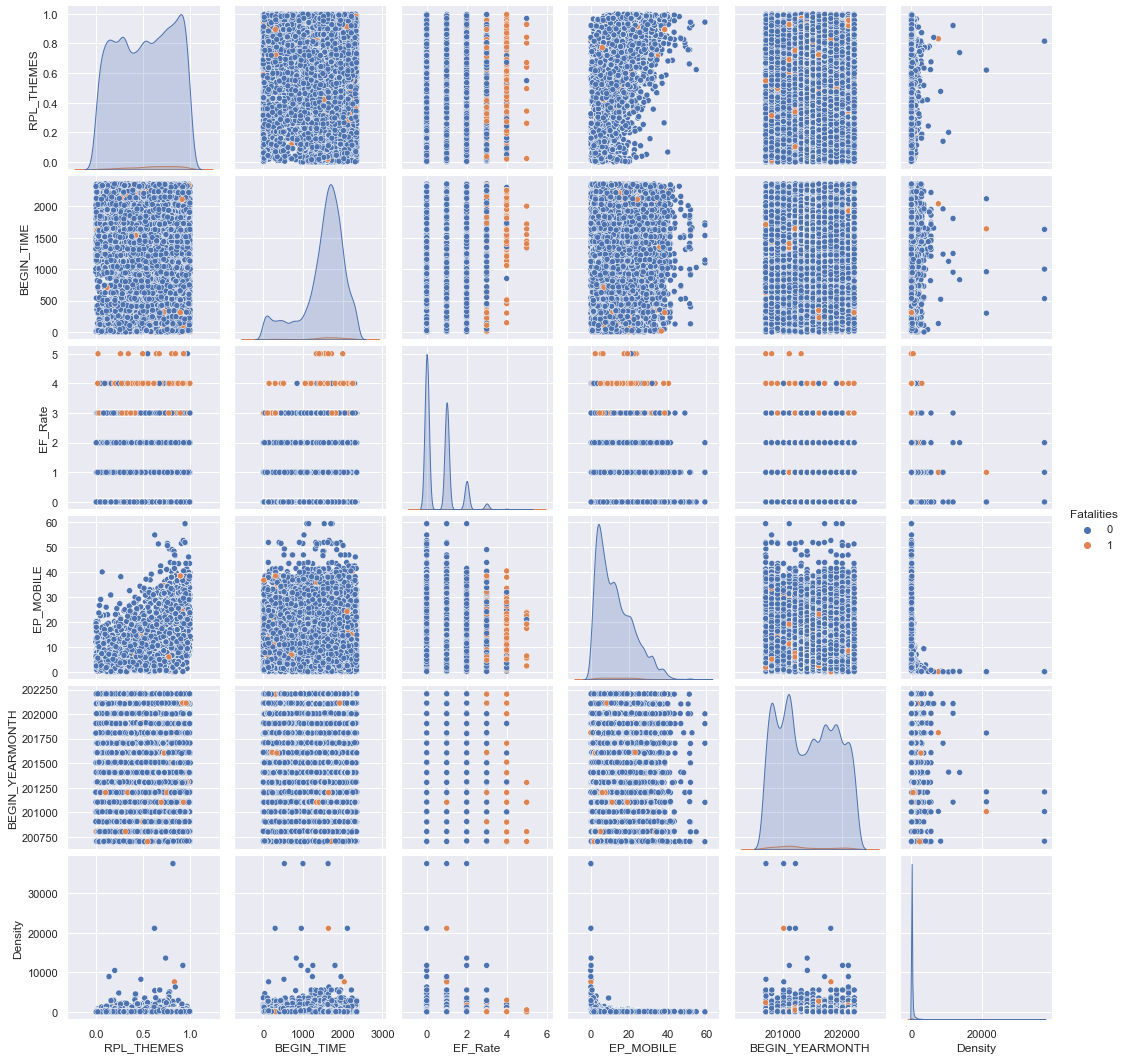

In [157]:
sns.pairplot(cdc_test, hue='Fatalities')

In [158]:
months = []
cold = []
for i in range(0, len(cdc_test), 1):
    temp = str(int(cdc_test.BEGIN_YEARMONTH.iloc[[i]]))[-2:]
    months.append(temp)

for i in range(0, len(months), 1):
    temp2 = months[i]
    temp2 = int(temp2)
    if temp2==12 or temp2==1 or temp2==2:
        temp3 = 1
    else:
        temp3 = 0
    cold.append(temp3)

cdc_test['DJF'] = cold

months = []
cold = []
for i in range(0, len(cdc_test), 1):
    temp = str(int(cdc_test.BEGIN_YEARMONTH.iloc[[i]]))[-2:]
    months.append(temp)

for i in range(0, len(months), 1):
    temp2 = months[i]
    temp2 = int(temp2)
    if temp2==3 or temp2==4 or temp2==5:
        temp3 = 1
    else:
        temp3 = 0
    cold.append(temp3)

cdc_test['MAM'] = cold

months = []
cold = []
for i in range(0, len(cdc_test), 1):
    temp = str(int(cdc_test.BEGIN_YEARMONTH.iloc[[i]]))[-2:]
    months.append(temp)

for i in range(0, len(months), 1):
    temp2 = months[i]
    temp2 = int(temp2)
    if temp2==6 or temp2==7 or temp2==8:
        temp3 = 1
    else:
        temp3 = 0
    cold.append(temp3)

cdc_test['JJA'] = cold

months = []
cold = []
for i in range(0, len(cdc_test), 1):
    temp = str(int(cdc_test.BEGIN_YEARMONTH.iloc[[i]]))[-2:]
    months.append(temp)

for i in range(0, len(months), 1):
    temp2 = months[i]
    temp2 = int(temp2)
    if temp2==9 or temp2==10 or temp2==11:
        temp3 = 1
    else:
        temp3 = 0
    cold.append(temp3)

cdc_test['SON'] = cold
cdc_test = cdc_test.drop('BEGIN_YEARMONTH', axis=1)

In [136]:
test = []

for i in cdc_test.BEGIN_TIME:
    if i <= 600:
        f = 1
    elif i >= 2200:
        f = 1
    else:
        f= 0
    test.append(f)


cdc_test['NIGHT'] = test

cdc_test = cdc_test.drop('BEGIN_TIME', axis=1)

In [137]:
cdc_test

,RPL_THEMES,EF_Rate,EP_MOBILE,Fatalities,Density,DJF,MAM,JJA,SON,NIGHT
0,0.4557,0,12.8,0,77.642872,0,0,1,0,0
2,0.0761,1,7.2,0,392.038769,0,1,0,0,0
3,0.9494,1,5.3,0,38.024616,0,0,0,1,0
4,0.7271,0,4.2,0,340.668073,0,1,0,0,1
5,0.4557,0,12.8,0,77.642872,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
21315,0.3780,2,18.9,0,34.442842,0,0,1,0,0
21316,0.8981,0,13.2,0,3.839782,0,0,1,0,0
21317,0.7959,0,33.4,0,2.368853,0,0,1,0,0
21318,0.7586,1,27.8,0,58.744499,0,0,1,0,0


In [138]:
cdc_test1 = cdc_test.drop('RPL_THEMES', axis=1)
# cdc_test1 = cdc_test1.drop('EP_MOBILE', axis=1)
#cdc_test1 = cdc_test1.drop('Density', axis=1)
# cdc_test1 = cdc_test1.drop('DJF', axis=1)
# cdc_test1 = cdc_test1.drop('MAM', axis=1)
# cdc_test1 = cdc_test1.drop('JJA', axis=1)
# cdc_test1 = cdc_test1.drop('SON', axis=1)
# cdc_test1 = cdc_test1.drop('NIGHT', axis=1)
# cdc_test1 = cdc_test.drop('EF_Rate', axis=1)

In [139]:
#Seperate our input data from our target data
X_cdc = cdc_test1.drop('Fatalities', axis=1)
y_cdc = cdc_test1['Fatalities']

In [140]:
# Split our data into a training dataset and a testing dataset
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_cdc, y_cdc,
                                                random_state=0, train_size=0.8)

In [141]:
# Fit our random forest regressor to the training data
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(bootstrap=True, n_estimators=200, 
            min_samples_leaf=4, min_samples_split=5, max_depth=5)
forest.fit(Xtrain, ytrain)

RandomForestRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=200)

In [142]:
# Create a set of predictions from our test data using the model
ypredict = forest.predict(Xtest)

In [143]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Calculate our r squared and RMSE values to compare how this models 
# predictions performed compared to the actual values.
R2 = r2_score(ytest, ypredict)
print(f'The correlation coefficient of the model is {R2}')
RMSE = (mean_squared_error(ytest, ypredict))**0.5
print(f'The RMSE of the model is {RMSE}')

The correlation coefficient of the model is 0.33693608708590217
The RMSE of the model is 0.10748009334208258


Cross-Validation

In [147]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(forest, X_cdc, y_cdc, cv=10)

In [148]:
scores

array([0.22553232, 0.18251959, 0.28613281, 0.32638384, 0.26033548,
       0.15725279, 0.26369659, 0.18043038, 0.22081664, 0.4057424 ])

In [149]:
scores.mean()

0.2508842834426367

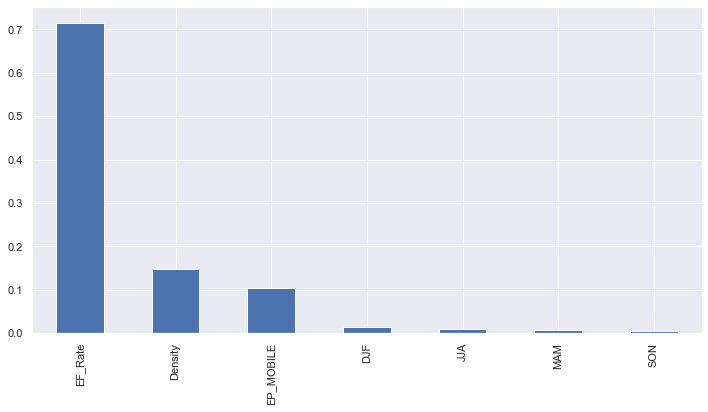

In [86]:
# Plot the feature importances of the random forest regressor
importances = pd.Series(forest.feature_importances_)
importances.index = X_cdc.columns
importances.sort_values(inplace=True, ascending=False)
importances.plot.bar(figsize=(12,6))
plt.show()

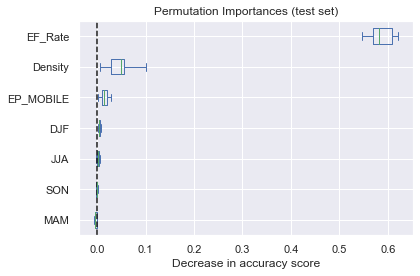

In [87]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, Xtest, ytest, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_cdc.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [65]:
import shap
shap.initjs()

In [66]:
explainer = shap.Explainer(forest)
shap_test = explainer(Xtest)
shap_values = explainer.shap_values(X_cdc)

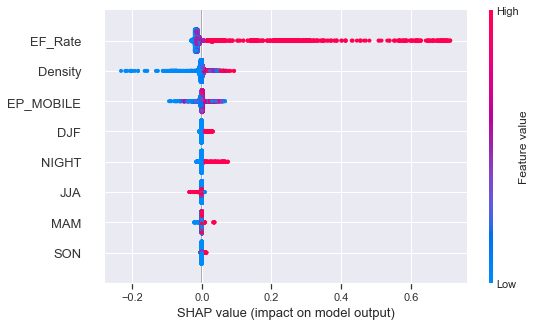

In [67]:
shap.summary_plot(shap_values, X_cdc)

In [68]:
ytest_index = ytest.reset_index(drop=True)

In [69]:
failed = []
incorrect = []
correct = []

for i in range(0, 100, 5):
    j = i/100
    ypredict_binary = []
    for i in range(0, len(ypredict), 1):
        if ypredict[i]>=j:
            m = 1
        else:
            m = 0
        ypredict_binary.append(m)

    test = []
    how_wrong = []
    for c in range(0, len(ytest), 1):
        if ytest_index[c]==0 and ypredict_binary[c]==0:
            #m=1
            f=0
        elif ytest_index[c]==1 and ypredict_binary[c]==0:
            #m=0
            f=1
        elif ytest_index[c]==0 and ypredict_binary[c]==1:
            #m=0
            f=2
        elif ytest_index[c]==1 and ypredict_binary[c]==1:
            #m=1
            f=0
        #test.append(m)
        how_wrong.append(f)
        
    failed.append(how_wrong.count(1))
    incorrect.append(how_wrong.count(2))
    correct.append(how_wrong.count(0))

In [70]:
vals = []
for i in range(0, 100, 5):
    j = i/100
    vals.append(j)

(0.965, 0.995)

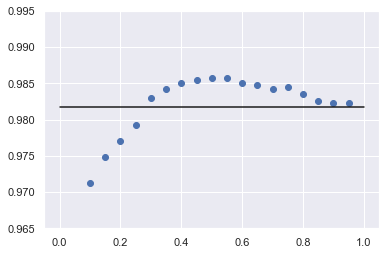

In [71]:
percent = [k/len(ypredict_binary) for k in correct]
plt.scatter(vals, percent)
plt.plot([0, 1], [0.9817, 0.9817], c='k')
plt.ylim([0.965, 0.995])

In [152]:
percent

[0.01773669747689233,
 0.9335498376217837,
 0.9712715463402448,
 0.9747689233075194,
 0.9770172370721959,
 0.9792655508368724,
 0.9830127404446665,
 0.9842618036472646,
 0.9850112415688234,
 0.9855108668498626,
 0.9857606794903823,
 0.9857606794903823,
 0.9850112415688234,
 0.9847614289283038,
 0.9842618036472646,
 0.9845116162877842,
 0.9835123657257058,
 0.9825131151636273,
 0.9822633025231077,
 0.9822633025231077]

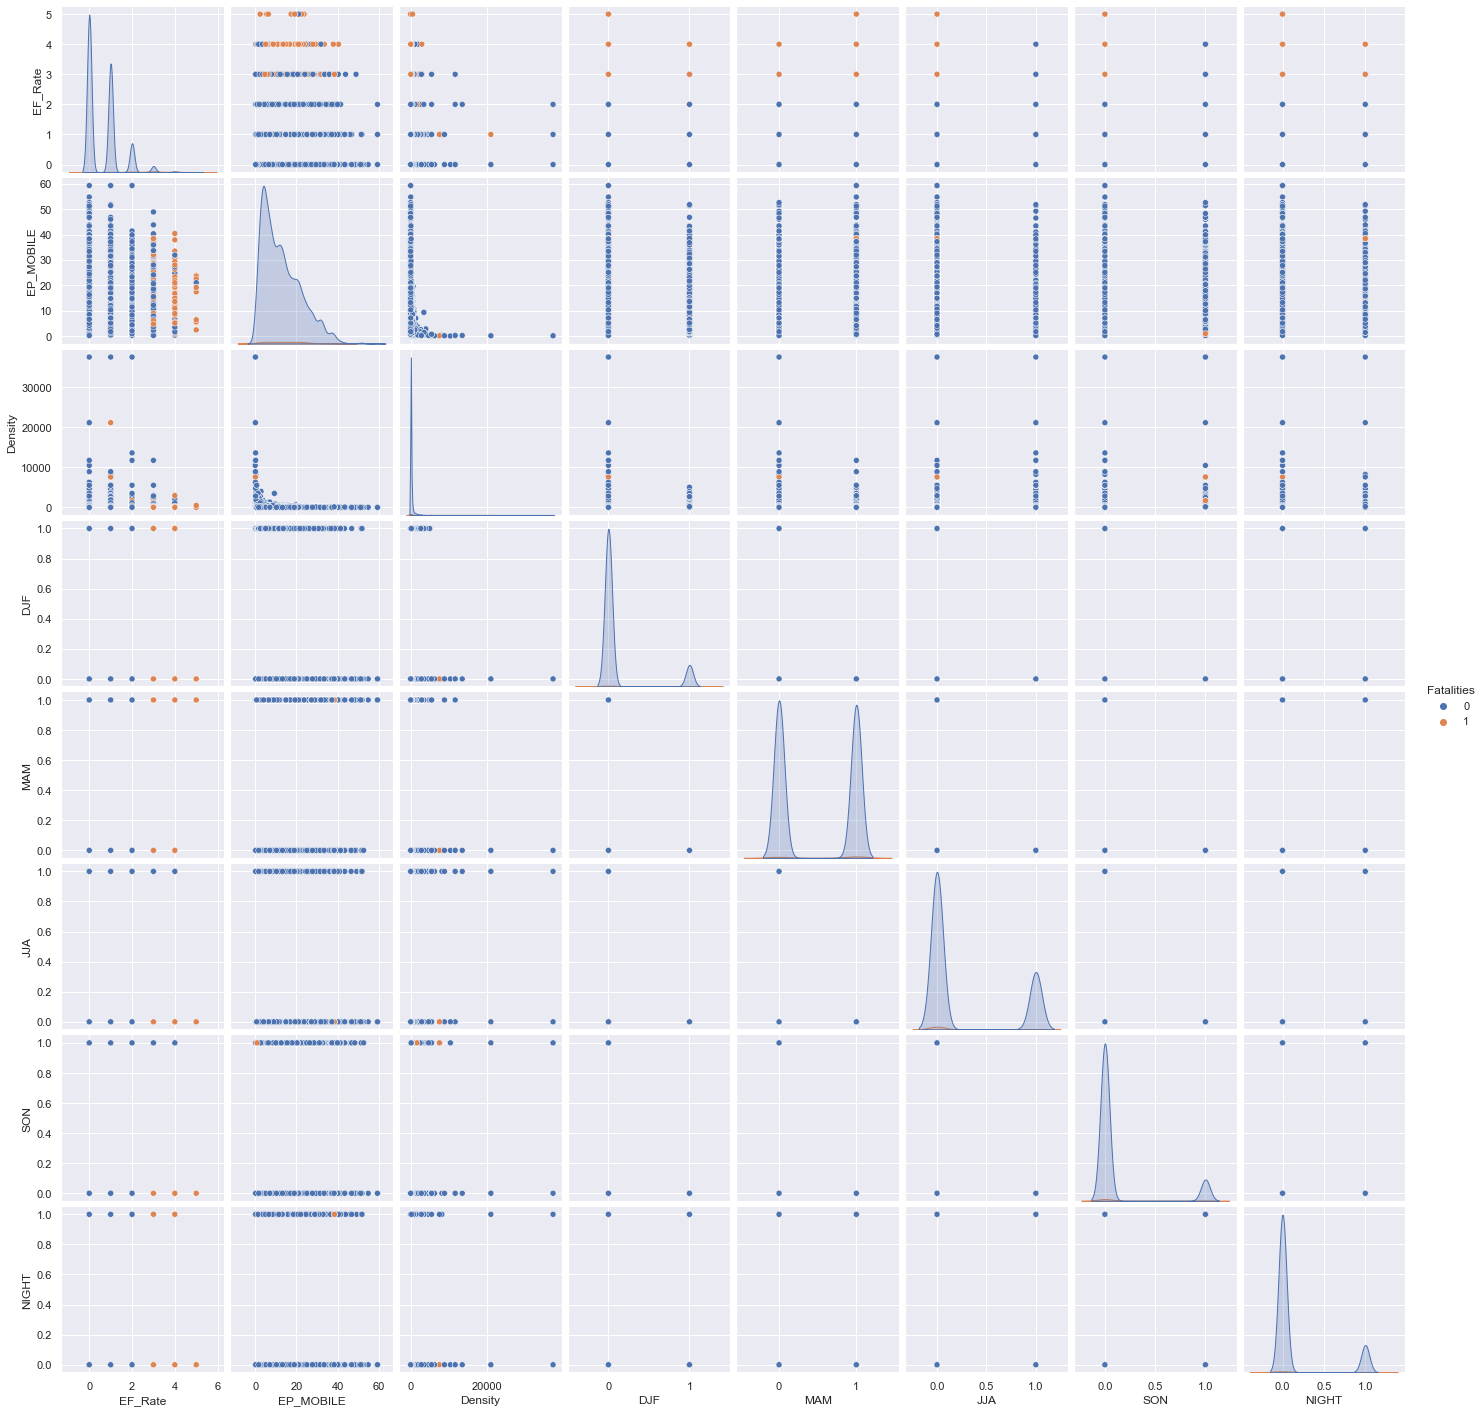

In [114]:
sns.pairplot(cdc_test1, hue='Fatalities')